In [7]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
from IPython.display import display

import sys
sys.path.insert(0, "../src")

from juart.conopt.functional.fourier import (
    nonuniform_fourier_transform_adjoint,
)
from juart.conopt.linops.identity import IdentityOperator
from juart.conopt.linops.tf import TransferFunctionOperator
from juart.conopt.proxops.linear import conjugate_gradient
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.phantoms.ellipsoid.ellipsoids import SheppLogan

# 2D iterative-NUFFT

In [8]:
fov = [0.2, 0.2]
matrix = [256, 256]
echo_sig = [1, 0.7]

## Create radial trajectory

In [9]:
# Create first readout line at y=0
kx = (torch.arange(matrix[0]) - matrix[0] / 2) * 1 / fov[0]

num_spokes = int(torch.pi / 2 * matrix[0])
d_phi = torch.tensor(torch.pi / num_spokes)

k = torch.zeros((2, num_spokes, kx.size(0)), dtype=torch.float32)
for n in range(num_spokes):
    k[0, n, :] = kx * torch.cos(d_phi * n)
    k[1, n, :] = kx * torch.sin(d_phi * n)

k = k.view(2, -1)

## Create analytic kspace signal

In [10]:
phantom = SheppLogan(
    fov=fov,
    matrix=matrix,
)

signal = phantom.get_arb_kspace(k)

# Add channel dim
signal = signal[None, ...]

## Reconstruction

In [11]:
# Scale k from -0.5 to 0.5
k = k * (fov[0] / matrix[0])

In [12]:
transfer_function = nonuniform_transfer_function(
    k, data_shape=(1, matrix[0], matrix[1], 1)
)

regridded_data = nonuniform_fourier_transform_adjoint(
    k,
    signal,
    n_modes=tuple(matrix),
    modeord=0,
)

transfer_function_operator = TransferFunctionOperator(
    transfer_function, regridded_data.shape, axes=(1, 2)
)

ident_operator = IdentityOperator(
    regridded_data.shape,
)

In [16]:
# Calculate CG-NUFFT solution with regularization
residual = []
reg_param = 0.001
d_vec = regridded_data.view(torch.float32).ravel()
init_guess = torch.rand(d_vec.shape, dtype=torch.float32)
ATA = transfer_function_operator + reg_param * ident_operator

img,residual = conjugate_gradient(
    A=ATA,
    b=d_vec,
    x=init_guess,
    maxiter=100,
    residual = residual
)

img = img.view(torch.complex64).reshape(regridded_data.shape)

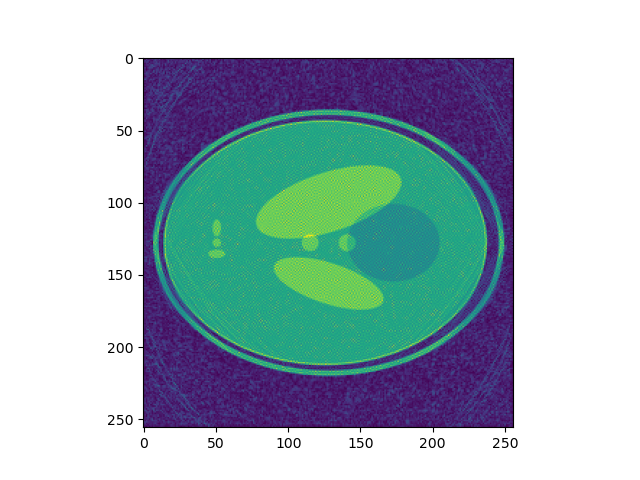

In [17]:
plt.figure()
plt.imshow(torch.abs(img[0, ..., 0]))

# 3D iterative-NUFFT

Calculate the 3D cg-NUFFT for a stack-of-stars trajectory

In [18]:
fov = [0.2, 0.2, 0.2]
matrix = [128, 128, 128]

## Create stack-of-stars trajectory

In [19]:
# Create first readout line at y=0
kx = (torch.arange(matrix[0]) - matrix[0] / 2) * 1 / fov[0]
kz = (torch.arange(matrix[2]) - matrix[2] / 2) * 1 / fov[2]

num_spokes = int(torch.pi / 2 * matrix[0])
d_phi = torch.tensor(torch.pi / num_spokes)

k = torch.zeros((3, matrix[0], num_spokes, matrix[2]), dtype=torch.float32)
for part in range(matrix[2]):
    for n in range(num_spokes):
        k[0, :, n, part] = kx * torch.cos(d_phi * n)
        k[1, :, n, part] = kx * torch.sin(d_phi * n)
    k[2, :, :, part] = kz[part]

k = k.view(3, -1)

## Create analytic kspace signal

In [20]:
phantom = SheppLogan(
    fov=fov,
    matrix=matrix,
)

signal = phantom.get_arb_kspace(k)

# Add channel dim
signal = signal[None, ...]

## Reconstruction

In [21]:
# Scale k from -0.5 to 0.5
k = k * (fov[0] / matrix[0])

In [22]:
regridded_data = nonuniform_fourier_transform_adjoint(
    k,
    signal,
    n_modes=tuple(matrix),
    modeord=0,
)

transfer_function = nonuniform_transfer_function(k, data_shape=regridded_data.shape)

transfer_function_operator = TransferFunctionOperator(
    transfer_function, regridded_data.shape, axes=(1, 2, 3)
)

ident_operator = IdentityOperator(
    regridded_data.shape,
)

In [23]:
# Calculate CG-NUFFT solution with regularization
residual = []
reg_param = 0.001
d_vec = regridded_data.view(torch.float32).ravel()
init_guess = torch.zeros_like(d_vec, dtype=torch.float32)
ATA = transfer_function_operator + reg_param * ident_operator

img, reidual = conjugate_gradient(
    A=ATA,
    b=d_vec,
    x=init_guess,
    maxiter=20,
    residual = residual
)

img = img.view(torch.complex64).reshape(regridded_data.shape)
img /= torch.max(torch.abs(img))

IntSlider(value=64, description='Slice', max=127)

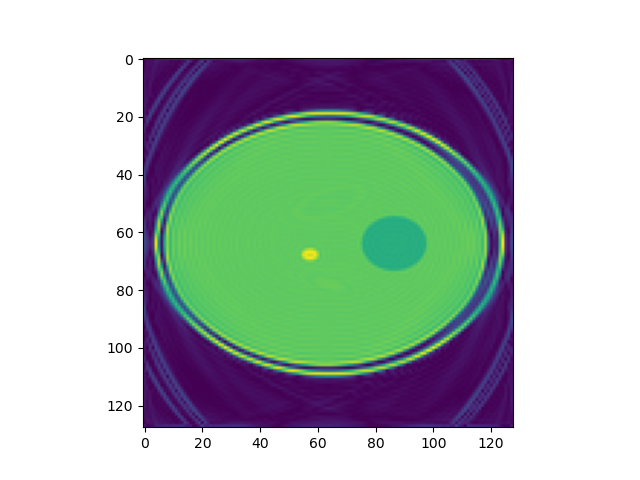

In [24]:
plt.figure()

shw = plt.imshow(torch.abs(img[0, :, :, 64]))


def update(z):
    shw.set_data(torch.abs(img[0, :, :, z]))
    shw.title(f"Slice {z}")


z_slider = widgets.IntSlider(
    value=64,
    min=0,
    max=matrix[2] - 1,
    step=1,
    description="Slice",
    continuous_update=True,
)

widgets.interactive(update, z=z_slider)
display(z_slider)